# Stability Analysis of mStable coin

In [1]:
import os, sys
import requests
import pandas as pd
import numpy as np
from datetime import timedelta as td, datetime as dt, timezone
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

# Scripts
scripts_module_path = os.path.abspath(os.path.join(os.getcwd(),'..', 'scripts'))
if scripts_module_path not in sys.path:
    sys.path.append(scripts_module_path)
from acquisition import Acquisition as Akw
from handling import getDataFrame, addReversionAndVolatility, addAverages
from viz import createBasicAnalysisPlot

In [17]:
# common keywords
basic_kwargs = dict(granularity='days')

# required for data acquisition
acquisition_kwargs = dict(**basic_kwargs,
                          datetime_from=dt.now() - td(days=523),
                          datetime_till=dt.now(),
                          downloadIfMissing=True,
                          includeOffPeg=True)
# required for the estimation of the reversion rate
reversion_kwargs = dict(**basic_kwargs,
                        windowSize=85,
                        minDataPoints=60,
                        discount_factor = 0.1,
                        sampleError=0.0001,
                        verbose=True)

## Reversion rate of mStable

In [3]:
Akw.updateDataLocally(whichData="cg_musd_usd")

200

In [18]:
musd = getDataFrame(whichData="cg_musd_usd", **acquisition_kwargs)
musd_df = addReversionAndVolatility(musd, **reversion_kwargs)
addAverages(musd_df, columns=["price", "rate", "sigma"], com=5, inplace=True)

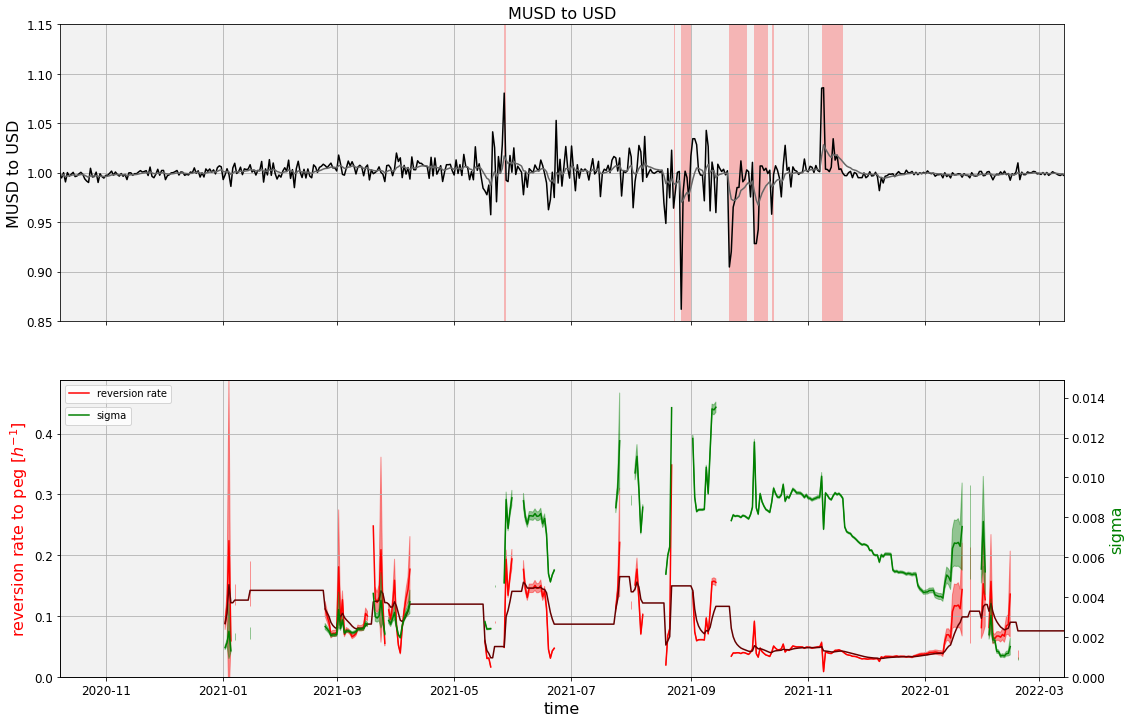

In [22]:
fig, axes, secax = createBasicAnalysisPlot(df=musd_df, title="MUSD to USD", price_dev=0.08)
axes[0].plot(musd_df.date, musd_df.price_ewm, color="#666")
axes[1].set_ylim([0,musd_df.rate.max()*(1+0.4)])
secax[1].set_ylim([0,musd_df.sigma.max()*(1+0.1)])
axes[1].plot(musd_df.date, musd_df.rate_ewm, color="#600")
axes[0].set_ylim([0.85,1.15])
axes[0].fill_between(musd_df["date"], 0.8, 1.15, 
                where=(musd_df.price_ewm>1.01) | (musd_df.price_ewm<0.99),
                facecolor='red',
                alpha=0.25)
plt.show()

The first figure shows the price action of `MUSD` against `USD` as recorded by coingecko. The grey line shows an exponentially weighted moving average, whose value keeps fairly close to the peg. Only at those times indicated by the red bars does the exponential average of `MUSD` temporarily loose its peg.

The average reversion rate (`red`) seems to be more or less hovering around 0.1. There are occasional depeg-spikes which are however quickly (or almost immediately) recovered. Thus, the volatility (`green`) does go up towards the latter part of 2021, but since has come down again.